In [ ]:
import networkx as nx
import itertools
import random
%matplotlib inline


# Lab 6

This notebook is a slightly revised copy of Chapter 5 tutorial by F. Menczer, S. Forunato, C.A. Davis, *A First Course in Network Science* (Cambridge 2020), available at: https://cambridgeuniversitypress.github.io/FirstCourseNetworkScience/ followed by additional exercises. The contents of the tutorials have been adapted by KAK providing some additional comments which might be relevant for the HN students, the exercises have been included to allow students further work on the data they previously worked with in Week 3. 

Contents:
1. Tutorials 

    1.1. Python's random module

    1.2. Random network model

    1.3. Small-World model

    1.4. Preferential attachment model

    *For each of the models presented in this tutorial, we present the algorithm, an example implementation, and the corresponding NetworkX code function to generate the model. The implementations provided in this tutorial are written for clarity, not for efficiency; it's best to use the NetworkX functions when doing real analysis work.*


2. Exercises

    2.1. Exercise 1: Graph Comparison - NetworkX

    2.2. Exercise 2: Graph Comparison - Gephi





## Tutorials 
### 1.1 Python's `random` module

Many network models rely on randomness in their generative algorithms. Python's [random module](https://docs.python.org/3.7/library/random.html) provides four key functions of use when coding network models.

### `random.random`

Often in an algorithm, we need something to happen with some probability $p$. The canonical way to decide whether or not such an event happens is to generate a random number $r$ between 0 and 1, and if $r < p$, then the event occurs. The [random.random()](https://docs.python.org/3.7/library/random.html#random.random) function returns just such a random number in the interval [0, 1).

For a simple example, consider an unfair coin that comes up heads 75% of the time. We can write the following code to flip such a coin 10 times, reporting the outcome each time:

In [ ]:
p = 0.75

# Do this 10 times
for _ in range(10):
    r = random.random()
    if r < p:
        print('Heads')
    else:
        print('Tails')

As we would expect from a random process, executing the previous cell again will generate a different sequence of flips -- each one is independently generated.

###  `random.choice`

When we have a population of discrete choices and we need to select one at random, we use [random.choice()](https://docs.python.org/3.7/library/random.html#random.choice). For example, instead of "[eeny, meeny, miny, moe](https://en.wikipedia.org/wiki/Eeny,_meeny,_miny,_moe)," we can use random.choice to choose a random name:

In [ ]:
names = ['Alice', 'Bob', 'Cathy', 'Dan']
random.choice(names)

### `random.sample`

If we have a collection and we need to select more than one element without replacement, we use [random.sample()](https://docs.python.org/3.7/library/random.html#random.sample). For example, to choose two nodes at random from the nodes in a graph, we can use the following:

In [ ]:
G = nx.cycle_graph(5)
random.sample(G.nodes, 2)

### `random.choices`

We use [random.choices()](https://docs.python.org/3.7/library/random.html#random.choices) when we need to choose an element from a collection when the chances of selecting each element are not identical.

For an example, let's assume Alice, Bob, and Carol are in a raffle drawing. 
Alice bought one ticket, 
Bob bought three tickets, 
and Carol bought four tickets. 

We can simulate ten different draws of this raffle, replacing the drawn ticket each time. 

*Note: Replacing in this context means that the items are being put back into the pool after being picked, so even though there are just 8 tickets, if we put them back after each draw we can still draw 10 times.*

In [ ]:
names = ['Alice', 'Bob', 'Carol']
tickets = [1, 3, 4]

for _ in range(10):
    print(random.choices(names, tickets))

Running the above cell should give what we expect: Carol wins the drawing most often, with Bob winning some times, and Alice winning occasionally. Of course this outcome depends on the luck of the draw!

The same can be done without using the loop described above. Instead we will be using the argument `k=` and specifying its value to the desired number of draws. 

So we can choose *k* items from the collection *with replacement* (putting the items back after each draw):

In [ ]:
random.choices(names, tickets, k=10)

The weights provided to `random.choices` (in our case specified as `tickets`) do not have to be integers -- any numeric weights are fine.

## 2. Random Network Model

The random network model, as formulated by Gilbert, has two parameters: the number of nodes $N$, and the link probability $p$. 

As described in our textbook (Menczer, chapter 5), the algorithm for creating this network is as follows:

1. Select a pair of nodes, say i and j.
2. Generate a random number r between 0 and 1. 
3. If r < p, then add a link between i and j.
4. Repeat for all pairs of nodes.

We'll need a couple of tools from Python for this task:

### Generating combinations

We've previously looped over all nodes in a graph, as well as all graph edges, but this algorithm requires us to loop over all *pairs* of nodes, *i.e.* all possible edges. The `itertools` module in Python's standard library gives us the [combinations()](https://docs.python.org/3.7/library/itertools.html#itertools.combinations) function, an elegant way to loop over pairs of elements in a sequence:

In [ ]:
elements = [0, 1, 2, 3, 4]
list(itertools.combinations(elements, 2))

The second argument to `itertools.combinations()` is the length of the sequences we want in the output. Since we want pairs, we'll specify 2. 

Note the nice properties of the output:

1. No repeat elements -- we don't want to consider self-loops like `('a', 'a')`.
2. Pairs are in sorted order -- `('a', 'b')` and `('b', 'a')` are the same edge in an undirected graph.

We can thus use this to loop over all pairs of nodes in a graph:

In [ ]:
G = nx.Graph()
G.add_nodes_from(elements)

list(itertools.combinations(G.nodes, 2))

### Gilbert random graph model

With these tools in our toolbelt, we can code the algorithm for the Gilbert random graph model.

In [ ]:
def gnp_random_graph(N, p): # N - number of nodes, p - probability
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    for i, j in itertools.combinations(G.nodes, 2):
        r = random.random()
        if r < p:
            G.add_edge(i, j)
        # Do nothing if r >= p
        
    return G

We can use this function to generate a graph. Since this is a random graph, each execution of the following code will generate a different graph. 

In [ ]:
G = gnp_random_graph(16, 0.15)
nx.draw(G)
print('Graph has', G.number_of_edges(), 'edges.')

Run the above cell a few times and note that the number of edges varies slightly among random graphs generated with the same parameters. This is because each pair of nodes has an independent chance of being an edge.

### Erdös-Rényi random graph model

Instead of specifying the link probability $p$, we can also generate a graph of $N$ nodes with exactly $M$ edges by using `random.sample()` to choose M of the possible edges generated with `itertools.combinations()`:

In [ ]:
def gnm_random_graph(N, M): # N - number of nodes, M - number of edges
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    possible_edges = itertools.combinations(G.nodes, 2)
    edges_to_add = random.sample(list(possible_edges), M)
    G.add_edges_from(edges_to_add)
    
    return G

In [ ]:
G = gnm_random_graph(16, 18)
nx.draw(G)

### NetworkX functions

NetworkX has a function for the $G_{n,p}$ random graph specifying number of nodes $N$ and link probability $p$: `gnp_random_graph` (n, p, seed=None, directed=False, *, create_using=None), as is described here: [gnp_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html).

NetworkX also provides a function which generates a $G_{n,m}$ graph, where we specify the number of nodes $N$ and the desired number of edges $M$.

`gnm_random_graph` (n, m, seed=None, directed=False, *, create_using=None), as described here: 
 [gnm_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnm_random_graph.html)

## 3. Small-World Model

The algorithm for generating a small-world network is as such:

1. Begin with a ring of $N$ nodes
2. Connect each node to its $k$ nearest neighbors (or $k-1$ if $k$ is odd).
3. For each edge $(u, v)$, with probability $p$, replace edge $(u, v)$ with $(u, w)$ where $w$ is not a neighbor of $u$.

We'll do these step-by-step first, and combine them into a function last.

### Create a ring of N nodes

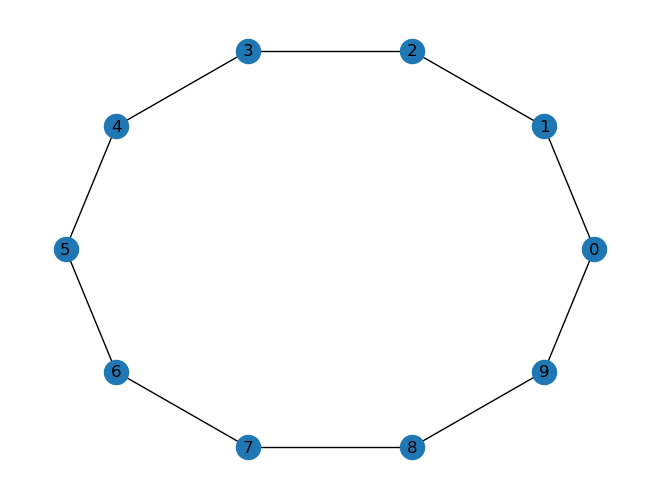

In [98]:
N = 10
G = nx.cycle_graph(N)
nx.draw_circular(G, with_labels=True)

### Connect each node to its $k$ nearest neighbors (or $k-1$ if $k$ is odd).

Let's assume that for node $n$, we want to add edges to $n$'s 4 nearest neighbors.
Since our nodes are in a circle, these can "wrap around", *e.g.* the 4 nearest neighbors of node $n$ are $n-2$, $n-1$, $n+1$ and $n+2$.

Look at the graph above and find 4 nearest neighbours of node 6.

   - n-2 = 4  
   - n-1 = 5  
   - n+1 = 7
   - n+2 = 9 
   
What about node 9.

- n-2 = 7
- n-1 = 8
- n+1 = 10 (called 0 here)
- n+2 = 11 (called 1 here, why?  we have only 10 nodes? What do we need to do we need to wrap it around)

Let's write a code which will connect all the nodes in our network to its 4 nearest neighbours. 

 
       

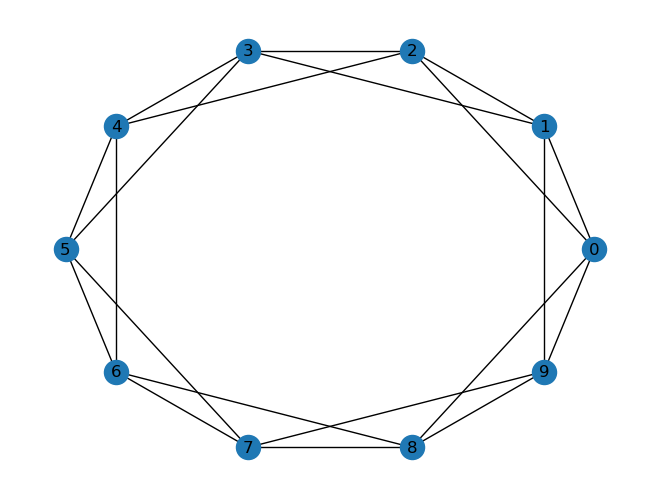

In [99]:
k = 4 # Choose the number of the nearest neighbours to which you want to connect your nodes.

# Iterate over all nodes in the graph G
for n in G.nodes:
    # Loop through a range from 1 to half of k to find neighbors at distances i
    '''
    We are dealing with circular network, so nodes have left and right neighbours. 
    We will use integer division (//) floor division. 
    //  divides two numbers and rounds *down* the result to the nearest whole number (integer). 
    So it ignores the decimal part and gives you the largest integer, 
    which is *less than* or *equal* to the result.
    So 9 // 4 gives you 2 (as 9/4 = 2.25, round down 2.25, we get 2) 
    and 11 // 4 gives you also 2 (as 11/4 = 2.75,round down 2.75, we get 2). 
    
    Note also the use of the `range` function. 
    Do you know why we add 1? 
    The `range(start, stop)` function generates numbers from start to stop - 1 
    (stop is exclusive). 
    So if you want to include a value, and we do because we want to reach our neighbours 
    you need to add 1 to the stop value.

    We also use modulo for wrapping, described below. 
    
    '''
    for i in range(1, k // 2 + 1):
        # Calculate the left neighbor index, wrapping around the graph size using modulo
        left  = (n-i) % N 
        # Calculate the right neighbor index, again using modulo for wrapping
        right = (n+i) % N 
        ''' If you do not remember how modulo works, 
            here comes a simple 
            definition of modulo. 
            For any number a % b, 
            the result is the remainder when dividing a by b.
            a mod b = a − b × a//b 
                Where:
                    a is the number you're finding the modulo of.
                    b is the divisor (modulus).
                    a//b is the floor division of a by b, which rounds down to the nearest whole number.

            You can think of modulo (%) as answering:
            "What number do I add to get a multiple of b?"

            Example: 4 mod 9
            Look for the nearest multiple of 9 that is smaller than 4
            The multiples of 9 are: ... -18, 9, 0, 9, 18 ... 9*n
            The nearest one less than 4 is 0.
            How far is 4 from 0?
            4
            So 4 mod 9 is 4. 

            Example: -3 % 6
            Look for the nearest multiple of 6 that is smaller than -3
            The multiples of 6 are: ... -12, -6, 0, 6, 12 ... 6*n
            The nearest one less than -3 is -6.
            How far is -3 from -6?
            3
            So -3 mod 6 = 3
        '''
        G.add_edge(n, left)# Add an edge from the current node 'n' to the left neighbor
        G.add_edge(n, right)# Add an edge from the current node 'n' to the right neighbor


# Ok, so now let's see the graph check whether node 9 is connected to 7 (n-1), 8 (n-2), 10 (n+1, so 0) and 11 (n+2, so 1).
nx.draw_circular(G, with_labels=True)

 

### Rewire some edges

> For each edge $(u, v)$, with probability $p$, replace edge $(u, v)$ with (u, w) where $w$ is not a neighbor of $u$.

For this step, we make use of set arithmetic in order to generate a list of nodes that are not neighbors of $u$, and `random.choice` to select $w$ at random from that set of "not neighbors."

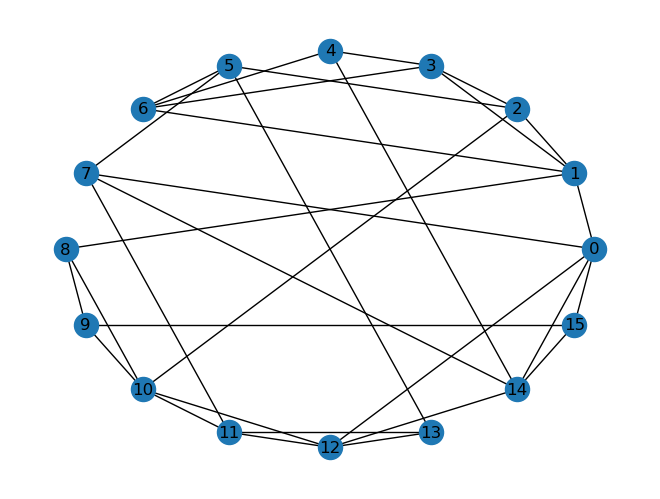

In [ ]:
p = 0.1 # probability for rewiring 

for u, v in list(G.edges):
    if random.random() < p: # we skip the loop for generating r that we used above
        not_neighbors = set(G.nodes) - set(G.neighbors(u)) # create a list of non-neighbours, 
        w = random.choice(list(not_neighbors)) # select a node from non-neighbours
        G.remove_edge(u, v) # remove the original link between u and v
        G.add_edge(u, w) # create a new link between u and w. 

nx.draw_circular(G, with_labels=True)

### Watts-Strogatz Small-World Model

We can put this together to write a basic function for the small-world model:

In [141]:
def watts_strogatz_graph(N, k, p):
    # 1. Create a ring of N nodes
    G = nx.cycle_graph(N)

    # 2. Connect each node n to k nearest neighbors
    #    [n-(k//2), ... , n-1, n+1, ... , n+(k//2)]
    for n in G.nodes:
        for i in range(1, k // 2 + 1):
            left  = (n-i) % N
            right = (n+i) % N 
            G.add_edge(n, left)
            G.add_edge(n, right)
    
    # 3. Rewire edges with probability p
    for u, v in list(G.edges):
        if random.random() < p:
            not_neighbors = set(G.nodes) - set(G.neighbors(u)) - {u}
            w = random.choice(list(not_neighbors))
            G.remove_edge(u, v)
            G.add_edge(u, w)

    return G

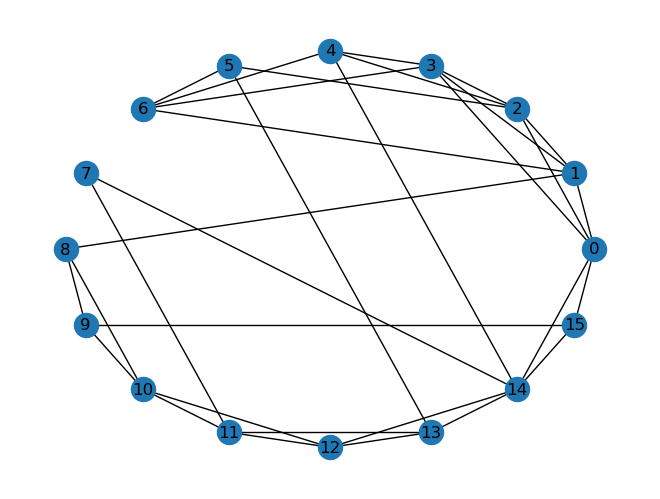

In [156]:
G = watts_strogatz_graph(16, 4, 0.2)
nx.draw_circular(G, with_labels=True)

### NetworkX function

NetworkX has a function `watts_strogatz_graph`(n, k, p, seed=None, *, create_using=None) which can generate graphs $G$ according to this model, where $n$ is the number of nodes, $k$ is the number of nearest neighbours to join, and $p$ is the probability of rewiring, see: [watts_strogatz_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html).

## 4. Preferential Attachment Model

The Barabási-Albert preferential attachment model has two parameters: the number of nodes $N$, and the number of links added at each step $m$. Given these parameters, the algorithm is as follows:

1. Start with a clique of $m + 1$ nodes.
2. Select $m$ different nodes at random, weighted by their degree.
3. Add a new node $i$ and link it with the $m$ nodes from the previous step.
4. Repeat 2-3 until there are N nodes in the graph.

The code for this is thus straightforward, with one possible exception: 
for step 3, we need to generate a *degree sequence* to weight the random selection. If we have a graph `G`, we can generate such a degree sequence with a list comprehension as follows:

In [ ]:
G = nx.star_graph(4)
degrees = [G.degree(n) for n in G.nodes]

print(degrees)
nx.draw(G, with_labels=True)

Note that the degree sequence is output in the same order as the nodes, such that the node at index $i$ in that list has the degree at index $i$ of the corresponding degree sequence. With this, we can write a function for the BA preferential attachment model:

In [ ]:
def barabasi_albert_graph(N, m): # N number of nodes, m the number of links added at each step 
    # 1. Start with a clique of m+1 nodes
    G = nx.complete_graph(m + 1)
    for i in range(G.number_of_nodes(), N):
        # 2. Select m different nodes at random, weighted by their degree.
        new_neighbors = []
        possible_neighbors = list(G.nodes)
        for _ in range(m):
            degrees = [G.degree(n) for n in possible_neighbors]
            j = random.choices(possible_neighbors, degrees)[0]
            new_neighbors.append(j)
            possible_neighbors.remove(j)
        
        # 3. Add a new node i and link it with the m nodes from the previous step.
        for j in new_neighbors:
            G.add_edge(i, j)

    return G

In [ ]:
G = barabasi_albert_graph(30, 1)
nx.draw(G)

One might wonder why, in the previous code for `preferential_attachment_graph`, we didn't just write step 2 as

    new_neighbors = random.choices(G.nodes, degrees, k=m)
    
The issue here is that when one specifies $k > 1$ for `random.choices`, the selection is made with replacement, *i.e.* the same node can be selected from the list multiple times. The more complicated code is necessary so that we choose $m$ different nodes to join with node $i$.

### NetworkX function

NetworkX has a function `barabasi_albert_graph`(n, m, seed=None, initial_graph=None, *, create_using=None) which can  generate graphs $G$ according to the BA model, where n is the number of nodes, and m is the number of edges to attach from a new node to the existing nodes, see: [barabasi_albert_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html).

## Exercises

### Exercise 1: Graph comparison - NetworkX 





1. Using the US open flights data that we worked with in Week 3, check how many nodes and edges are in this network.  
    You can find the data here: https://github.com/KAKDH/ENC_HN_NA/tree/main/labs/data

2. Using these numbers create a random network with NetworkX, experiment with at least 2 different probability values.

3. Plot both networks in this notebook and compare them visually. What differences do you see? 

4. Save both visualisations as images AND export both graphs using the NetworkX export. 
    Use the export form of your choice. In class we used Pajek and GraphML, but you can find a list of NetworkX supported file formats here: https://networkx.org/documentation/stable/reference/readwrite/index.html.

### Exercise 2: Graph comparison - Gephi

1. Import both graphs from Exercise 1 to Gephi. 
    If you have not installed Gephi before class, you can find it here: https://gephi.org/users/download/
    You can find Gephi tutorial here to find out how to import your data: https://gephi.org/users/quick-start/ 

2. Run Force Atlas 2 algorithm on both networks, compare them visually.  

3. Run basic statistic measures on both networks (starting with degree -> "Average Degree" from "Statistics"). 
    Save the "Degree Distribution" chart from the pop-up window for both graphs.
    Compare the numbers and distributions. 

4. Using toolbox Appearance/Nodes/ (on the left in default settings) make nodes with higher degree larger (Size -> Ranking -> Degree, Min size 1 max size 10) and nodes with higher betweenness centrality darker (Colour Palette -> Ranking -> Betweenness Centrality, choose your colour). Any differences between the two graphs? 